# Benchmark Pauli operator projection

### Pauli string action on a computational basis state

The action of a Pauli string on a computational basis state is rather trivial, and just a single computational basis state itself. This is a direct consequence of the structure of Pauli matrices, which only have a single nonzero element on each of their rows. Consequently, their action on a qubit is:

-------------------------------------------

$$
\sigma_x |0 \rangle = |1 \rangle
$$

$$
\sigma_x |1 \rangle = |0 \rangle
$$

-------------------------------------------

$$
\sigma_y |0 \rangle = i|1 \rangle
$$

$$
\sigma_y |1 \rangle = -i|0 \rangle
$$

-------------------------------------------

$$
\sigma_z |0 \rangle = |0 \rangle
$$

$$
\sigma_z |1 \rangle = -|1 \rangle
$$

-------------------------------------------

$$
I |0 \rangle = |0 \rangle
$$

$$
I |1 \rangle = |1 \rangle
$$

-------------------------------------------

Each bit on the bitstring labeling the computational basis will be labeled by $x \in \{0, 1 \}$. In order to keep the implementation at light as possible, we will
represent the bitstrings with `bool` variables: $0\rightarrow \textrm{False}$ and
$1\rightarrow \textrm{True}$.

To represent the action of each Pauli operator in a computational basis state
we will assign three variables to it: `diag`, `sign`, `imag`. 
- `diag` labels whether the operator is diagonal:
    - $\textrm{diag}(I) = \textrm{True}$
    - $\textrm{diag}(\sigma_x) = \textrm{False}$
    - $\textrm{diag}(\sigma_y) = \textrm{False}$
    - $\textrm{diag}(\sigma_z) = \textrm{True}$
- `sign` Identifies if there is a sign change in the matrix element connected 
to either 0 or 1:
    - $\textrm{diag}(I) = \textrm{False}$
    - $\textrm{diag}(\sigma_x) = \textrm{False}$
    - $\textrm{diag}(\sigma_y) = \textrm{True}$
    - $\textrm{diag}(\sigma_z) = \textrm{True}$
- `imag` Identifies if there is a complex component to the matrix element:
    - $\textrm{diag}(I) = \textrm{False}$
    - $\textrm{diag}(\sigma_x) = \textrm{False}$
    - $\textrm{diag}(\sigma_y) = \textrm{False}$
    - $\textrm{diag}(\sigma_z) = \textrm{True}$

Let's label an arbitrary Pauli operator as $\sigma \in \{ I, \sigma_x, \sigma_y
\sigma_z\}$. The action of the Pauli operator on a computational basis state 
can then be represented by the logic operation:
$$
\sigma |x \rangle = |x == \textrm{diag}(\sigma) \rangle (-1)^{x\textrm{ and sign}(\sigma)}
(i)^{\textrm{imag}(\sigma)}.
$$
The same is straightforwardly generalized to arbitrary number of qubits.

Let's check that this works:

In [1]:
import time

import numpy as np
from qiskit_addon_sqd.qubit import matrix_elements_from_pauli_string, sort_and_remove_duplicates


def connected_element_and_amplitude_bool(x, diag, sign, imag):
    """
    Finds the connected element to computational basis state |x> under
    the action of the Pauli operator represented by (diag, sign, imag).

    Args:
        x: Value of the bit, either True or False.
        diag: Whether the Pauli operator is diagonal (I, Z)
        sigma: Whether the Pauli operator's rows differ in sign (Y, Z)
        imag: Whether the Pauli operator is purely imaginary (Y)

    Returns:
        A length-2 tuple:
            - The connected element to x, either False or True
            - The matrix element
    """
    return x == diag, (-1) ** (x and sign) * (1j) ** (imag)


sigma_indices = [0, 1, 2, 3]
sigma_string = ["I", "SX", "SZ", "SY"]
sigma_diag = [True, False, True, False]
sigma_sign = [False, False, True, True]
sigma_imag = [False, False, False, True]
qubit_values = [False, True]

for xi in sigma_indices:
    print("-------------------")
    print(sigma_string[xi])
    for x in qubit_values:
        x_p, matrix_element = connected_element_and_amplitude_bool(
            x, sigma_diag[xi], sigma_sign[xi], sigma_imag[xi]
        )
        print("|" + str(x) + "> -->  |" + str(x_p) + ">    ME:" + str(matrix_element))

-------------------
I
|False> -->  |False>    ME:(1+0j)
|True> -->  |True>    ME:(1+0j)
-------------------
SX
|False> -->  |True>    ME:(1+0j)
|True> -->  |False>    ME:(1+0j)
-------------------
SZ
|False> -->  |False>    ME:(1+0j)
|True> -->  |True>    ME:(-1+0j)
-------------------
SY
|False> -->  |True>    ME:1j
|True> -->  |False>    ME:(-0-1j)


Let's generate some large number of bitstrings (50 M) for a 40-qubit system

In [2]:
rand_seed = 22
np.random.seed(rand_seed)

# Generate some random bitstrings for testing


def random_bitstrings(n_samples, n_qubits):
    return np.round(np.random.rand(n_samples, n_qubits)).astype("int").astype("bool")


n_qubits = 40
bts_matrix = random_bitstrings(50_000_000, n_qubits)

# We need to sort the bitstrings and just keep the unique ones
# NOTE: It is essential for the projection code to have the bitstrings sorted!
bts_matrix = sort_and_remove_duplicates(bts_matrix).astype("bool")

# Final subspace dimension after getting rid of duplicated bitstrings
d = bts_matrix.shape[0]

print("Total number of unique bitstrings: " + str(d))

Total number of unique bitstrings: 49998839


### Let's time the projection time for a Pauli String

The Pauli string under consideration is $\sigma_z \otimes ... \otimes \sigma_z$.

Different subspace dimensions are considered by just slicing the matrix of bitstrings. We time the subspace projection for the different subspace sizes.

In [3]:
pauli_str = ["Z" for i in range(n_qubits)]

# Different subspace sizes to test
d_list = np.linspace(d / 1000, d, 20).astype("int")

# To store the walltime
time_array = np.zeros(20)

for i in range(20):
    int_bts_matrix = bts_matrix[: d_list[i], :]
    time_1 = time.time()
    _ = matrix_elements_from_pauli_string(int_bts_matrix, pauli_str)
    time_array[i] = time.time() - time_1
    print(f"Iteration {i} took {round(time_array[i], 6)}s")

Iteration 0 took 0.31216s
Iteration 1 took 0.510622s
Iteration 2 took 0.775817s
Iteration 3 took 1.047106s
Iteration 4 took 1.354705s
Iteration 5 took 1.583962s
Iteration 6 took 1.846798s
Iteration 7 took 2.072656s
Iteration 8 took 2.313123s
Iteration 9 took 2.539087s
Iteration 10 took 2.831971s
Iteration 11 took 3.149036s
Iteration 12 took 3.36273s
Iteration 13 took 3.661241s
Iteration 14 took 3.998323s
Iteration 15 took 4.310177s
Iteration 16 took 4.654591s
Iteration 17 took 4.686089s
Iteration 18 took 5.002513s
Iteration 19 took 5.188594s


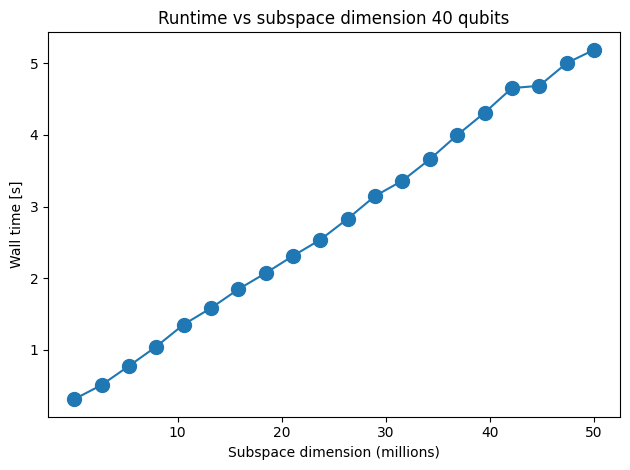

In [4]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = d_list
y1 = time_array

# Plot energies
plt.title("Runtime vs subspace dimension 40 qubits")
plt.xlabel("Subspace dimension (millions)")
plt.ylabel("Wall time [s]")
plt.xticks([1e7, 2e7, 3e7, 4e7, 5e7], [str(i) for i in [10, 20, 30, 40, 50]])
plt.plot(x1, y1, marker=".", markersize=20)
plt.tight_layout()
plt.show()

Let's do the same for 60 qubits

In [5]:
n_qubits = 60
bts_matrix = random_bitstrings(50_000_000, n_qubits)

# We need to sort the bitstrings and just keep the unique ones
bts_matrix = sort_and_remove_duplicates(bts_matrix).astype("bool")

# Final subspace dimension after getting rid of duplicated bitstrings
d = bts_matrix.shape[0]

print("Total number of unique bitstrings: " + str(d))

Total number of unique bitstrings: 50000000


In [6]:
pauli_str = ["Z" for i in range(n_qubits)]

# Different subspace sizes to test
d_list = np.linspace(d / 1000, d, 20).astype("int")

# It is better to do this once
row_array = np.arange(d)

# To store the walltime
time_array = np.zeros(20)

for i in range(20):
    int_bts_matrix = bts_matrix[: d_list[i], :]
    int_row_array = row_array[: d_list[i]]
    time_1 = time.time()
    _ = matrix_elements_from_pauli_string(int_bts_matrix, pauli_str)
    time_array[i] = time.time() - time_1
    print(f"Iteration {i} took {round(time_array[i], 6)}s")

Iteration 0 took 0.331874s
Iteration 1 took 0.604671s
Iteration 2 took 0.91632s
Iteration 3 took 1.219938s
Iteration 4 took 1.598329s
Iteration 5 took 1.9079s
Iteration 6 took 2.188979s
Iteration 7 took 2.530264s
Iteration 8 took 2.827899s
Iteration 9 took 3.154194s
Iteration 10 took 3.514766s
Iteration 11 took 3.83003s
Iteration 12 took 4.185016s
Iteration 13 took 4.514196s
Iteration 14 took 4.948467s
Iteration 15 took 5.388114s
Iteration 16 took 5.596917s
Iteration 17 took 5.776064s
Iteration 18 took 6.082537s
Iteration 19 took 6.356327s


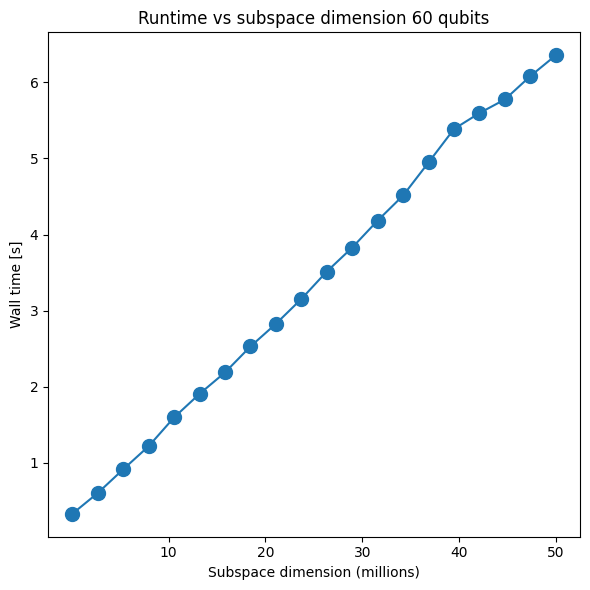

In [7]:
# Data for energies plot
x1 = d_list
y1 = time_array

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

# Plot energies
axs.plot(x1, y1, marker=".", markersize=20)
axs.set_title("Runtime vs subspace dimension 60 qubits")
axs.set_xlabel("Subspace dimension (millions)")
plt.xticks([1e7, 2e7, 3e7, 4e7, 5e7], [str(i) for i in [10, 20, 30, 40, 50]])
axs.set_ylabel("Wall time [s]")

plt.tight_layout()
plt.show()